### Import Libraries

In [1]:
import pandas as pd
import nltk
import re
import string
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification
from scipy.special import softmax
from nltk.corpus import stopwords
from wordcloud import WordCloud

nltk.download('stopwords')

c:\Users\hankc\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hankc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Enable GPU if available

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### File paths for different risk levels

In [5]:
file_paths = {
    "Low": "../41_input/avalanche_messages_1_low.csv",
    "Moderate": "../41_input/avalanche_messages_2_moderate.csv",
    "Considerable": "../41_input/avalanche_messages_3_considerable.csv",
    "High": "../41_input/avalanche_messages_4_high.csv",
    "Extreme": "../41_input/avalanche_messages_5_extreme.csv"
}

### Load datasets and combine into one dataframe

In [6]:
dataframes = []
for risk, path in file_paths.items():
    df = pd.read_csv(path)
    df["Risk_Level"] = risk
    dataframes.append(df)

df = pd.concat(dataframes, ignore_index=True)

### Load pre-trained BERT model and tokenizer

In [7]:
MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME).to(device)

### Helper Functions

In [8]:
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [9]:
def get_sentiment(text):
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        output = model(**encoded_input)
    scores = output.logits[0].cpu().numpy()
    scores = softmax(scores)
    sentiment_labels = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']
    return sentiment_labels[scores.argmax()]

### Apply preprocessing and sentiment analysis

In [ ]:
df['Cleaned_Message'] = df['Message'].apply(preprocess_text)
df['Sentiment'] = df['Cleaned_Message'].apply(get_sentiment)

### Map sentiment to numerical values

In [18]:
sentiment_mapping = {'Very Negative': -2, 'Negative': -1, 'Neutral': 0, 'Positive': 1, 'Very Positive': 2}
df['Sentiment_Score'] = df['Sentiment'].map(sentiment_mapping)

### Visualization

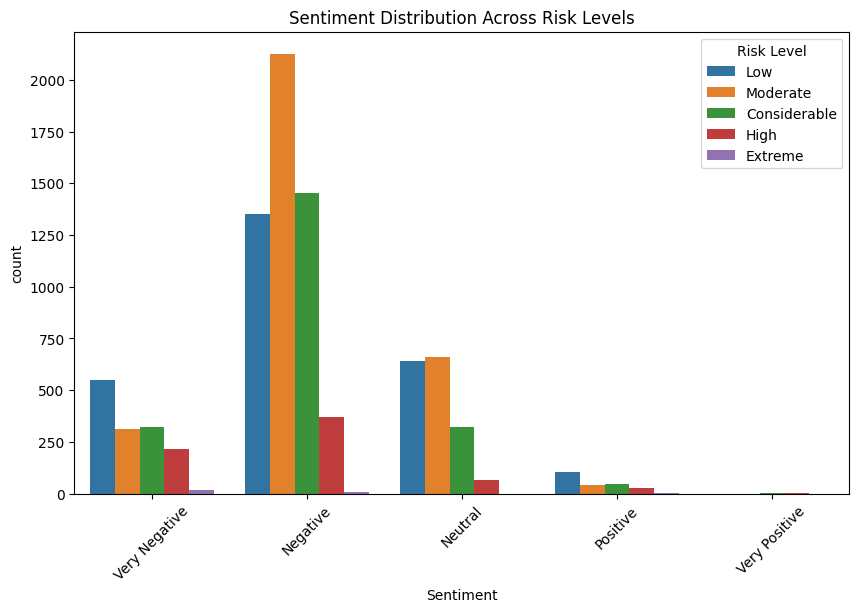

In [23]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df['Sentiment'], hue=df['Risk_Level'], order=['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])
plt.title('Sentiment Distribution Across Risk Levels')
plt.xticks(rotation=45)
plt.legend(title='Risk Level')
plt.show()

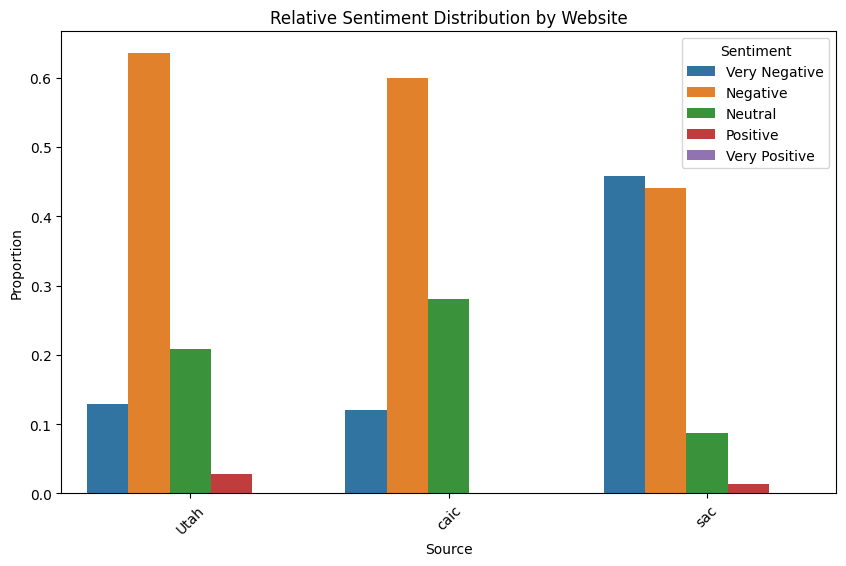

In [26]:
# Compute relative counts
grouped = df.groupby(['Source', 'Sentiment']).size().reset_index(name='count')
grouped['relative'] = grouped.groupby('Source')['count'].transform(lambda x: x / x.sum())

# Plot relative frequencies
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped, x='Source', y='relative', hue='Sentiment', hue_order=['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])
plt.title('Relative Sentiment Distribution by Website')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

### Generate Word Cloud

In [21]:
text_data = ' '.join(df['Cleaned_Message'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

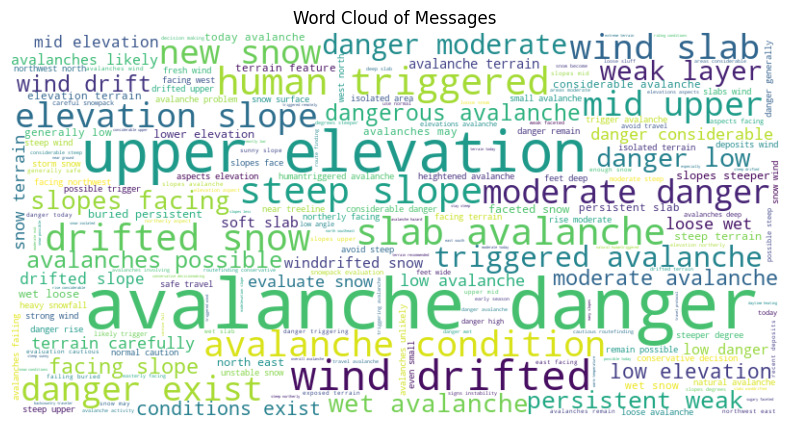

In [22]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud of Messages')
plt.show()

### Save processed data

In [ ]:
df.to_csv("../43_increment/processed_avalanche_data.csv", index=False)